In [1]:
"""Splitting a bunch of saved games into 2 parts:
1- Data for computing stats
2- Dataset to train model and predict in 10-fold CV
In fact, Stats is for previous data and that is why first we have to sort matches
and then choose an appropriate portion as stats and the rest for training and testing
"""

'Splitting a bunch of saved games into 2 parts:\n1- Data for computing stats\n2- Dataset to train model and predict in 10-fold CV\nIn fact, Stats is for previous data and that is why first we have to sort matches\nand then choose an appropriate portion as stats and the rest for training and testing\n'

# Imports

In [95]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pylab as plt
import scipy
import networkx
from scipy.sparse import csr_matrix
import networkx as nx
import glob
% matplotlib inline

# Useful Classes and Functions

In [163]:
def my_maximum (A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [3]:
"""Brief and useful info Match class"""
class Match:
    def __init__(self):
        self.summonerIds_championIds_isWinner_tier = []
        self.matchCreation = 0
        self.matchDuration = 0
        self.matchId = 0
        self.matchMode = ""
        self.matchType = ""
        
    def __init__(self, match):
        self.summonerIds_championIds_isWinner_tier = get_summonerIds_championIds_isWinner_tier(match)
        self.matchCreation = match['matchCreation']
        self.matchDuration = match['matchDuration']
        self.matchId = match['matchId']
        self.matchMode = match['matchMode']
        self.matchType = match['matchType']
        
    def __str__(self):
        return 'id:' + str(self.matchId) + ', mode:' + str(self.matchMode) + ', type:' + str(self.matchType) + ', creation:' + str(self.matchCreation) + ', duration:' + str(self.matchDuration) + ', my stats:' + str(self.summonerIds_championIds_isWinner_tier)
    

In [4]:
"""ChampionResult is a simple class with number of
    wins and loses as integer value"""
class ChampionResult:
    def __init__(self):
        self.wins = 0
        self.loses = 0
    
    def get_win_ratio(self):
        #assert self.wins + self.loses != 0, 'There is no matches available...'
        if not self.wins + self.loses:
            return 0
        return self.wins / float(self.wins + self.loses)
    
    def get_game_count(self):
        return self.wins + self.loses
        
        
"""SummonerChampionStats has a hashtable of champions which
    describes how many time summoner won or lost with that
    (GameResult as each item)"""
class SummonerChampionStats:
    def __init__(self):
        self.champions = defaultdict(lambda: ChampionResult())
    
    def get_game_count(self):
        return sum([c.get_game_count() for c in self.champions.values()])
    
    def get_win_ratio(self):
        w = sum([c.wins for c in self.champions.values()])
        l = sum([c.loses for c in self.champions.values()])
        #assert w + l != 0, 'There is no matches available...'
        if not w + l:
            return 0
        return w / float(w+l)
        
    def get_same_champion_game_count(self, champId):
        return self.champions[champId].get_game_count()
        
    def get_same_champion_win_ratio(self, champId):
        return self.champions[champId].get_win_ratio()
        

In [5]:
# preprocessing summoners from matches in order to have a dictionary of summoners with
#    a dictionary of their previous selected champions and GameResult for
#       for each selected champion (wins and loses)
def preprocess_given_matches(previous_matchIds_for_stats):
    summoners_stats = defaultdict(lambda: SummonerChampionStats())
    for mid in previous_matchIds_for_stats:
        summoner_champ_winner = matches[mid].summonerIds_championIds_isWinner_tier
        for s in summoner_champ_winner:
            if s[2]:
                summoners_stats[s[0]].champions[s[1]].wins += 1
            else:
                summoners_stats[s[0]].champions[s[1]].loses += 1
    return summoners_stats

Get the index for a sid in the network, it adds a new node if sid does not exist

In [6]:
def get_the_index_for_sid(sid):
    if sid not in sid_map:
        sid_map[sid] = len(sid_map)
    return sid_map[sid]

# in general format
def get_index_for(dictionary, val):
    if val not in dictionary:
        dictionary[val] = len(dictionary)
    return dictionary[val]

Get a list of network features for a given adjacency matrix

In [7]:
net_metric_names = ['AC', 'clustering', 'shortest_path_length', 'diameter', 'spectrum_v1', 'spectrum_v2', 'spectrum_v3', 'spectrum_v4', 'spectrum_v5']

def get_network_metrics(A):
    #nx.draw(A)
    return [nx.algebraic_connectivity(A), nx.average_clustering(A),
        nx.average_shortest_path_length(A) if nx.is_connected(A) else -1, 
            nx.diameter(A) if nx.is_connected(A) else -1] + list(nx.laplacian_spectrum(A))

Compute the weight between two nodes in the entire giant network 

In [184]:
def compute_weight_between_two_nodes_in_large_network(weighted_network, weighted_network_graph, n1, n2):
    assert type(weighted_network) == scipy.sparse.csr.csr_matrix, 'weighted_network is not a sparse matrix ...'
    assert type(weighted_network_graph) == networkx.classes.graph.Graph, 'weighted_network_graph is not a networkx graph ...'
    try:
        path = nx.shortest_path(weighted_network_graph, n1, n2)
    except:
        return 1000   # if there is not path and it has been raised nx.NetworkXNoPath then there is a large distance
    distance = 0
    for i in range(len(path)-1):
        distance += 1.0 / weighted_network[path[i], path[i+1]]
    return distance

# Start runing the script

In [8]:
# loading all saved matches
matches = {}
for fname in glob.glob("MATCHES_till_sid*.pkl"):
    print(fname)
    with open(fname, 'rb') as f:
        matches_chunk = pk.load(f)    
        matches = dict(matches.items()+matches_chunk.items())   # adding all matches together

MATCHES_till_sid512106.pkl
MATCHES_till_sid503154.pkl
MATCHES_till_sid35050.pkl
MATCHES_till_sid31287.pkl
MATCHES_till_sid4698.pkl
MATCHES_till_sid33108.pkl
MATCHES_till_sid515669.pkl
MATCHES_till_sid504948.pkl
MATCHES_till_sid5502.pkl
MATCHES_till_sid37119.pkl
MATCHES_till_sid1039.pkl
MATCHES_till_sid6755.pkl
MATCHES_till_sid10139.pkl
MATCHES_till_sid8499.pkl
MATCHES_till_sid3410.pkl
MATCHES_till_sid1900.pkl
MATCHES_till_sid509003.pkl
MATCHES_till_sid7780.pkl
MATCHES_till_sid28766.pkl
MATCHES_till_sid514117.pkl
MATCHES_till_sid603363.pkl


In [9]:
print 'Length of all matches is', len(matches)

Length of all matches is 208711


# Run after done loading and cleanning the data

Splitting the data into 2 sets

In [10]:
# selecting a sample of matches
SAMPLE_IT = False
if SAMPLE_IT:
    SAMPLE_SIZE = 10000
    sampled_matches_ids = [matches.keys()[s] for s in sorted(random.sample(range(len(matches)), SAMPLE_SIZE))]
else:  # all the data
    sampled_matches_ids = matches.keys()

# sorting matches with respect to their match creation date
dates = np.zeros(len(sampled_matches_ids))
for i, mid in enumerate(sampled_matches_ids):
    dates[i] = matches[mid].matchCreation
sampled_matches_ids_sorted = [x for (y,x) in sorted(zip(dates, sampled_matches_ids))]
#all(dates[i]<=dates[i+1] for i in range(len(dates)-1))  # for checking if this is sorted or no

# spliting the data to 70% for stats and 30% for dataset (train and test for 10-fold CV)
stats_len = int(0.7*len(sampled_matches_ids_sorted))
matchIds_for_stats = sampled_matches_ids_sorted[:stats_len]
matchIds_for_dataset = sampled_matches_ids_sorted[stats_len:]
print 'Length of matchIds_for_stats is', len(matchIds_for_stats), '\nLength of matchIds_for_dataset is', len(matchIds_for_dataset)

Length of matchIds_for_stats is 146097 
Length of matchIds_for_dataset is 62614


# Building the network of games from stats data

In [11]:
# finding the number of unique summoners
all_sids_in_stats = []
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    all_sids_in_stats+=[s[0] for s in sc]
N = len(set(all_sids_in_stats))
del all_sids_in_stats
print 'There are', N, 'unique summoners in the stats data.'

There are 638706 unique summoners in the stats data.


In [12]:
sid_map = {}
edges = defaultdict(lambda: 0)
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:   # if they were in the same team
                key = str(get_the_index_for_sid(sc[i][0])) + ',' + str(get_the_index_for_sid(sc[j][0]))
                edges[key] += 1
row, col, val = [], [], []
for k, v in edges.items():
    coordination = k.split(',')
    row.append(int(coordination[0]))
    col.append(int(coordination[1]))
    val.append(v)
# since N is so large, we build a sparse matrix to save the entire network in it
W = csr_matrix((val, (row, col)), shape=(N,N), dtype=np.int8)
del edges, row, col, val

/cs/student/omid55/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [161]:
W = my_maximum(W, np.transpose(W))

In [162]:
WG = nx.Graph(W)

This part may take a long time to run

In [14]:
# # degree distribution of the network
# plt.hist(sum(W).toarray())
# plt.title('Degree distribution in the entire network');

# Building the dataset from the second part (dataset)

Building the dataset

Data length is 17339


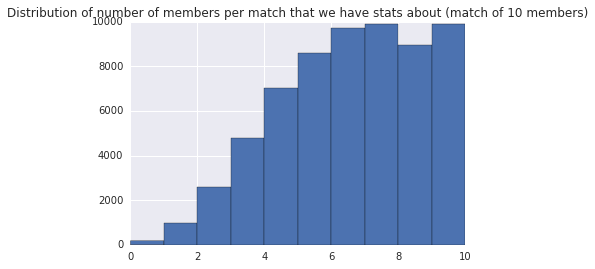

In [185]:
small_dataset = True

# preproccessing the stats part of data
summoners_stats = preprocess_given_matches(matchIds_for_stats)

# in each match how many of summoners have been seen in the stats before
c = np.zeros(len(matchIds_for_dataset))
for i, mid in enumerate(matchIds_for_dataset):
    for s in matches[mid].summonerIds_championIds_isWinner_tier:
        if s[0] in summoners_stats:
            c[i] += 1
plt.hist(c)
plt.title('Distribution of number of members per match that we have stats about (match of 10 members)');


# Actually building the dataset now:::
# for each match in the dataset
data = []
MIN_COUNT_MEMBER = 4  # minimum number of team members that we have information about
for mid in matchIds_for_dataset:
    # ------------------------------------------------------------------
    # check if we have enough information about this match of not. In fact if
    #   we have fewer than MIN_COUNT_MEMBER number of people with info, we should
    #   get rid of that match
    w = 0
    l = 0
    for s in matches[mid].summonerIds_championIds_isWinner_tier:
        if s[0] in summoners_stats:
            if s[2]:
                w += 1
            else:
                l += 1
    if w < MIN_COUNT_MEMBER or l < MIN_COUNT_MEMBER:
        continue
    # ------------------------------------------------------------------
    
    summoners_not_found_winner = 0
    summoners_not_found_loser = 0
    winners = []
    losers = []
    
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    
    # for team network 
    w_dict = {}
    l_dict = {}
    W_winner_team = np.zeros((5,5))
    W_loser_team = np.zeros((5,5))
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:
                if sc[i][0] in sid_map and sc[j][0] in sid_map:
                    if sc[i][2]:
                        ii = get_index_for(w_dict,i)
                        jj = get_index_for(w_dict,j)
                        W_winner_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                            (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                        W_winner_team[jj,ii] = W_winner_team[ii,jj]
                    else:
                        ii = get_index_for(l_dict,i)
                        jj = get_index_for(l_dict,j)
                        W_loser_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                            (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                        W_loser_team[jj,ii] = W_loser_team[ii,jj]
    # thus we have winner weights, loser weights
    #   and their adjacency matrix as W_winner_team, W_loser_team
    
    wg = nx.Graph(W_winner_team)
    lg = nx.Graph(W_loser_team)
    
    # for each member in each team
    for s in sc:
        stat = summoners_stats[s[0]]
        tmp = [
            stat.get_game_count(),
            stat.get_win_ratio(),
            stat.get_same_champion_game_count(s[1]),
            stat.get_same_champion_win_ratio(s[1])
        ]
        if s[2]:
            winners.append(tmp)
        else:
            losers.append(tmp)
       
    if small_dataset:
        sample = list(np.average(winners, axis=0)) + \
            list(np.std(winners, axis=0)) + \
            list(np.average(losers, axis=0)) + \
            list(np.std(losers, axis=0))
    else:
        sample = list(np.average(winners, axis=0)) + \
            list(np.std(winners, axis=0)) + \
            [np.average(sum(W_winner_team)),
            np.std(sum(W_winner_team))] + \
            get_network_metrics(wg) + \
            list(np.average(losers, axis=0)) + \
            list(np.std(losers, axis=0)) + \
            [np.average(sum(W_loser_team)),
            np.std(sum(W_loser_team))] +\
            get_network_metrics(lg)
               
    data.append(sample)

print 'Data length is', len(data)

# names for the features in the dataset
names = ['avg_game_count', 'avg_win_ratio', 'avg_same_champion_game_count', 'avg_same_champion_win_ratio', 
                     'std_game_count', 'std_win_ratio', 'std_same_champion_game_count', 'std_same_champion_win_ratio', 
                         'average_weight', 'std_weight'] + net_metric_names
feature_names = ['winner_' + na for na in names] + ['loser_' + na for na in names]

In [28]:
if small_dataset:
    dataset = pd.DataFrame(data=data, columns=['winner_avg_game_count', 'winner_avg_win_ratio', 'winner_avg_same_champion_game_count', 'winner_avg_same_champion_win_ratio', 
                                               'winner_std_game_count', 'winner_std_win_ratio', 'winner_std_same_champion_game_count', 'winner_std_same_champion_win_ratio', 
                                               'loser_avg_game_count', 'loser_avg_win_ratio', 'loser_avg_same_champion_game_count', 'loser_avg_same_champion_win_ratio', 
                                               'loser_std_game_count', 'loser_std_win_ratio', 'loser_std_same_champion_game_count', 'loser_std_same_champion_win_ratio' 
                                               ])
else:
    dataset = pd.DataFrame(data=data, columns= feature_names)

dataset.to_csv('Classification2016_Dataset.csv')

In [29]:
dataset.shape

(17339, 16)

In [30]:
dataset.head()

,winner_avg_game_count,winner_avg_win_ratio,winner_avg_same_champion_game_count,winner_avg_same_champion_win_ratio,winner_std_game_count,winner_std_win_ratio,winner_std_same_champion_game_count,winner_std_same_champion_win_ratio,loser_avg_game_count,loser_avg_win_ratio,loser_avg_same_champion_game_count,loser_avg_same_champion_win_ratio,loser_std_game_count,loser_std_win_ratio,loser_std_same_champion_game_count,loser_std_same_champion_win_ratio
0,2.8,0.396667,0.2,0.20000,1.600000,0.330723,0.400000,0.400000,65.4,0.604621,2.4,0.145455,97.641385,0.373021,4.317407,0.290909
1,84.8,0.432853,4.2,0.12381,165.602415,0.326502,8.400000,0.247619,1.6,0.100000,0.2,0.000000,0.489898,0.200000,0.400000,0.000000
2,191.0,0.635654,15.4,0.27500,357.155988,0.203928,28.323842,0.235112,9.2,0.662471,0.0,0.000000,9.108238,0.228489,0.000000,0.000000
3,2.0,0.266667,0.6,0.30000,1.095445,0.326599,0.800000,0.400000,64.8,0.713057,17.2,0.242949,97.043083,0.235038,30.557487,0.297759
4,1.4,0.533333,0.0,0.00000,1.019804,0.452155,0.000000,0.000000,18.6,0.604088,1.8,0.320000,16.752313,0.329222,2.227106,0.411825


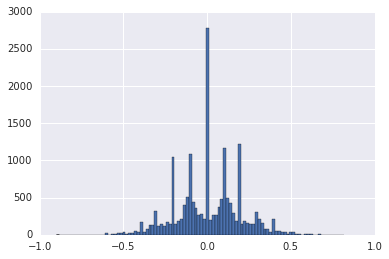

In [38]:
plt.hist(dataset['winner_avg_same_champion_win_ratio'] - dataset['loser_avg_same_champion_win_ratio'], bins=100);

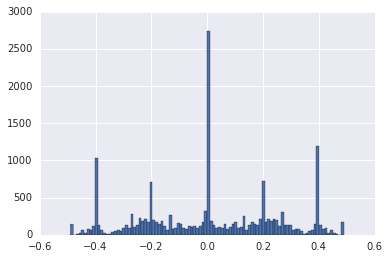

In [44]:
plt.hist(dataset['winner_std_same_champion_win_ratio'] - dataset['loser_std_same_champion_win_ratio'], bins=100);

In [ ]:
plt.hist(dataset['winner_std_same_champion_win_ratio'] - dataset['loser_std_same_champion_win_ratio'], bins=100);

In [47]:
print len(np.where(dataset['winner_std_same_champion_win_ratio'] - dataset['loser_std_same_champion_win_ratio']>0)[0])
print len(np.where(dataset['winner_std_same_champion_win_ratio'] - dataset['loser_std_same_champion_win_ratio']==0)[0])
print len(np.where(dataset['winner_std_same_champion_win_ratio'] - dataset['loser_std_same_champion_win_ratio']<0)[0])

7726
2423
7190


In [43]:
dt = dataset.ix[np.where(dataset['winner_avg_same_champion_win_ratio'] - dataset['loser_avg_same_champion_win_ratio']>-0.2)[0] and np.where(dataset['winner_avg_same_champion_win_ratio'] - dataset['loser_avg_same_champion_win_ratio']<0.2)[0]]
print(len(dt))
dt.to_csv('Classification2016_Dataset_Selected.csv')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
# np.where(dataset['winner_avg_same_champion_win_ratio'] - dataset['loser_avg_same_champion_win_ratio']>0)

# CLASSIFICATION

In [35]:
import classification_pipeline as pi
pi = reload(pi)
pi.run('Classification2016_Dataset_Selected.csv')

Starting ...
Loaded data size:  (14479, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (10000, 17)
                                classifier  test acc  train acc
0                                      KNN     60.31      70.81
1          Quadratic Discriminant Analysis     61.49      61.97
2                            Decision Tree     61.43      63.72
3             Linear Discriminant Analysis     62.84      63.05
4                      SVM with RBF kernel     62.53      66.45
5                              Naive Bayes     61.67      61.59
6                               Linear SVM     62.81      63.12
7                            Random Forest     61.46     100.00
8   Stochastic Gradient Descent Classifier     59.45      59.36
9                                 AdaBoost     62.33      63.78
10                     Logistic Regression     62.88      63.12
11                         Dummy (Uniform)     50.16      49.63
